# Automate the retrieval of PDF records for companies

For companies for which we can't find an electronic record in our database, we may be able to find and parse a PDF or electronic record using the Companies House API, which works by querying the filing history for a specific company and then requesting to download a specific document if we find one we want.

This can somewhat inflate the number of companies on which we have data.  As an aside, because our database includes only all digital records from 1 yr, a significant number of companies we didn't capture with that have electronic records that have either been uploaded since or just before the window from which the database was created.

### Biggest discovery so far
I need better decision rules for discovering which pages represent a balance sheet - because there are lots that are called "Statement of Financial Position" or some such.


### API URL information

Can get basic company information using;  GET https://api.companieshouse.gov.uk/company/{company_number}

Can get their filing history with;  GET https://api.companieshouse.gov.uk/company/{company_number}/filing-history

Can retrieve a specific document with;  GET http://document-api.companieshouse.gov.uk/document/{id}/content

In [19]:
import requests
import json
import shutil
import pymongo
import random
import importlib
import os
import pickle

import time as tic
import numpy as np
import pandas as pd

import xbrl_image_parser as xip
import xbrl_parser as xp

## Putting together the code for querying the Companies House API

In [20]:
information_url = "https://api.companieshouse.gov.uk/company/{}/filing-history"    # format with CH number
document_url = "GET http://document-api.companieshouse.gov.uk/document/{}" # format with doc id

In [21]:
# Gets an api key I saved to a text file (this stuff to avoid sharing the API key on GitHub)
with open("CH_api_key.txt") as f:
    key = f.read().split(":")[-1].strip()

In [ ]:
r = requests.get(information_url.format("00002404"), auth=(key, ""))

In [ ]:
r.json()

In [ ]:
# This finds all transaction id's for annual account documents

doc_ids = []

for each in r.json()['items']:
    
    if each['type'] == "AA":
        doc_ids.append( each['links']['document_metadata'])

doc_ids

In [ ]:
aa = requests.get(doc_ids[0] + "/content", auth=(key, ""))

In [ ]:
with open("test.pdf", "wb") as f:
        f.write(aa.content)

## Create a list of companies for which we don't have an electronic record on file

In [ ]:
# Connect to mongodb of digital records for purposes of cross-checking
# Believe I've previously generated an index on CH code so searching should be fast
import pymongo

cl = pymongo.MongoClient()
db = cl['CH_records']
col = db['digital_record_scrapes']

In [ ]:
counter = 0
recorded = 0

# Load the very large CSV in chunks (to fit within RAM)
for chunk in pd.read_csv("~/data/BasicCompanyDataAsOneFile-2018-10-01.csv", chunksize=1000):
    print("Loaded chunk {}, containing {} records".format(counter, len(chunk)))
    
    no_record = pd.DataFrame()
    
    # Iterate through the entries, checking if each exists in the database
    for index, row in chunk.iterrows():
        doc_count = col.count_documents({'doc_companieshouseregisterednumber':row[' CompanyNumber']})
        
        # If it doesn't, record it
        if doc_count == 0:
            no_record = no_record.append(row, ignore_index=True)
            recorded += 1
    
    # Append the discovered missing DB entries to the output csv file
    if (counter > 0) & (len(no_record) > 0):
        with open("./output/CH_no_digital_records.csv", 'a') as f:
            no_record.to_csv(f, mode='a', header=False, index=False)
            print("Saved a chunk")
    
    # Create a csv file for the discovered missing DB entries if one doesn't exist yet
    else:
        no_record.to_csv("./output/CH_no_digital_records.csv", index=False)
        print("Saved first chunk")
    
    counter += 1

In [ ]:
col.create_index('doc_companieshouseregisterednumber')

## Determine whether, for each file with no digital record, a paper record was submitted

For each entry in the "doesn't have an electronic record" csv file, see if it has a paper record instead by querying the Companies House API.  Record the date of the entry.

In [ ]:
check = pd.read_csv("./output/CH_no_digital_records.csv", nrows=1000)

results = pd.DataFrame()

for chnum in check[' CompanyNumber']:
    
    try:
        tic.sleep(.2)
        r = requests.get(information_url.format(chnum), auth=(key, ""))
        for each in r.json()['items']:
            results = results.append({"chnum":chnum,
                                      "type":each['type'],
                                      "desc":each['description'],
                                      "cat":each['category']}, ignore_index=True)
    
    except:
        continue

In [ ]:
results[['desc', 'type', 'chnum']].groupby(['desc', 'type']).agg('count')

In [ ]:
counter = 0

for chunk in pd.read_csv("./output/CH_no_digital_records.csv", chunksize=100):
    
    results = pd.DataFrame()
    
    for index, row in chunk.iterrows():
        
        # Wait for 2/10th of a second - this to accomodate rate limiting by CH to 600 requests/minute
        tic.sleep(.2)
        
        try:
            r = requests.get(information_url.format(row[' CompanyNumber']), auth=(key, ""))
        except:
            continue

        doc_dates = []
            
        try:
            for each in r.json()['items']:
    
                if each['type'] in ["AA", "AAMD", "BS"]:
                    doc_dates.append( each['date'])
        
            row['num_paper_records'] = len(doc_dates)
            row['paper_record_dates'] = ":".join(doc_dates)
            row['response_code'] = r.status_code
            
            results = results.append(row, ignore_index=True)
            
        except:
            row['num_paper_records'] = None
            row['paper_record_dates'] = None
            row['response_code'] = r.status_code
            
            results = results.append(row, ignore_index=True)

    # Append the discovered missing DB entries to the output csv file
    if (counter > 0) & (len(chunk) > 0):
        with open("./output/CH_no_digital_records_searched.csv", 'a') as f:
            results.to_csv(f, mode='a', header=False, index=False)
            print("Saved a chunk.  Reporting latest:", r.status_code, doc_dates)
    
    # Create a csv file for the discovered missing DB entries if one doesn't exist yet
    else:
        results.to_csv("./output/CH_no_digital_records_searched.csv", index=False)
        print("Saved first chunk")
    
    counter += 1

In [ ]:
counter

## Calculate the percentage of companies for which there's  no digital record, for which there IS a pdf record

In [22]:
pdf_df = pd.read_csv("./output/CH_no_digital_records_searched.csv")

/home/martin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,8,9,10,11,12,33,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
pdf_df.head()

,CompanyNumber,ConfStmtLastMadeUpDate,PreviousName_1.CompanyName,PreviousName_10.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CompanyName,PreviousName_4.CompanyName,PreviousName_5.CompanyName,PreviousName_6.CompanyName,...,Returns.LastMadeUpDate,Returns.NextDueDate,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,URI,num_paper_records,paper_record_dates,response_code
0,11399177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,03/07/2019,47710 - Retail sale of clothing in specialised...,NaN,NaN,NaN,http://business.data.gov.uk/id/company/11399177,0.0,NaN,200.0
1,11006939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,08/11/2018,62090 - Other information technology service a...,NaN,NaN,NaN,http://business.data.gov.uk/id/company/11006939,0.0,NaN,200.0
2,SC606050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,19/09/2019,41100 - Development of building projects,NaN,NaN,NaN,http://business.data.gov.uk/id/company/SC606050,0.0,NaN,200.0
3,09152972,30/07/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30/07/2015,27/08/2016,58190 - Other publishing activities,NaN,NaN,NaN,http://business.data.gov.uk/id/company/09152972,4.0,2018-09-05:2017-08-03:2017-06-05:2016-04-06,200.0
4,FC031362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None Supplied,NaN,NaN,NaN,http://business.data.gov.uk/id/company/FC031362,5.0,2018-12-24:2017-12-11:2016-09-12:2015-09-08:20...,200.0


In [24]:
# Little custom function for checking dates in the paper_record_dates field
def check_recent(dates_str, limit=2017):
    try:
        years = [int(x[0:4])>=limit for x in dates_str.split(":")]
    except:
        return(False)
    
    return(sum(years) > 0)

In [25]:
# Create a field reporting if there's a recent paper record
pdf_df['recent_record_exists'] = pdf_df['paper_record_dates'].apply(check_recent)

In [26]:
percent_paper = sum(pdf_df['recent_record_exists']) * 100.0 / len(pdf_df)
percent_paper

38.43813051963087

## Download a Random Sample of 1000 files

In [56]:
random.seed(7)
samples_df = pdf_df[pdf_df['recent_record_exists'] == True].sample(n=1000)

In [57]:
pdf_counter = 0
times_download = {}

for index, row in samples_df.iterrows():
    
    try:
        t0 = tic.time()
        # Get information about a company, includes a list of filed documents
        r = requests.get(information_url.format(row[' CompanyNumber']), auth=(key, ""))
        tic.sleep(0.1)
    
        # Extract a list of filed documents (tuple of links and dates)
        docs = []
        for each in r.json()['items']:
        
            # Get any document that has type "Annual Accounts", "Annual Accounts Modified", "Balance Sheet"
            if each['type'] in ["AA", "AAMD", "BS"]:
            
                # Detect if the document was filed as a "paper" account that was scanned
                try:
                    paper_filed = each['paper_filed']
                except:
                    paper_filed = False
            
                # record all this metadata
                docs.append( (each['links']['document_metadata'],
                            int(each['date'][0:4]),
                            each['date'],
                            paper_filed) )

        # select the most recent document
        dates = [x[1] for x in docs]
        max_index = dates.index(max(dates))
    
        print(docs[max_index])
    
        try:
            aa = requests.get(docs[max_index][0] + "/content", auth=(key, ""))
    
        except:
            tic.sleep(0.2)
            try:
                aa = requests.get(docs[max_index][0] + "/content", auth=(key, ""))
            
            except:
                print("Failed on " + row[' CompanyNumber'])
                continue
        
        
        if "pdf" in aa.headers['Content-Type']:
            file_end = ".pdf"
            pdf_counter += 1
            
        else:
            file_end = ".html"
        
        t1 = tic.time()
        times_download[row[' CompanyNumber']] = t1-t0
        
        #with open("./api_requested_documents/" + row[' CompanyNumber'] + "_" + docs[max_index][2] + file_end, "wb") as f:
        #    f.write(aa.content)
        #tic.sleep(0.1)
    
    except Exception as e:
        print("Failed on ", row[' CompanyNumber'])
        print(e)
        continue
        
print(pdf_counter)

('https://frontend-doc-api.companieshouse.gov.uk/document/QlleFCvOoBaNE5cPBr2m51pruODNwhrO4d46tADKObs', 2018, '2018-11-26', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/jE6hgHwivsX_GfjtETAninwuSRztqFE2gqiUZaJVsmg', 2017, '2017-11-15', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/VHpS1v9thqc1D6eSDawEH8r9JP7Ku8TBxDnEW4JleJI', 2018, '2018-07-31', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/OMC0udkxtH4_ga1ZORbClmUt8q1-mcTjch0zjVzSoDs', 2018, '2018-08-09', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/YNzm2fB6Yz-zWTvEe_WyBYJrP3mvl2Y5ms5VfFRi_Vc', 2018, '2018-04-23', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/qhrtOEGk5G7nFmTSwaL-iG3dFUU-0BOd9zeAvqlr29U', 2018, '2018-09-03', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/W-ttLkXK9BeZSYhsmM8mV1RgL0tB0NNy1WQ1ncRxNBM', 2019, '2019-01-02', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/4rrBrHugoOp0eWk9gbu7ANb1k8ISE

('https://frontend-doc-api.companieshouse.gov.uk/document/rLiSdUkuCrq6a0As73aqJR2qUB4WFdU0eZEhhkZPU2c', 2017, '2017-06-19', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/3_bARxHnvgCtfGdtkA2awPRfjG9UC1URRjpluaXEy4k', 2018, '2018-12-05', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/VHD3SqGhYcjuASXt9J0eGDVBowNSje_FKV-07lkNTZE', 2018, '2018-11-28', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/iP2Fdlz3RiQFjtY586ass0cMJBfkzPITUmY3L6eUxK8', 2018, '2018-09-28', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/eZegenH5AgHdzu4JQQ5uP24broYNMu9x5NY9J-3kMto', 2018, '2018-10-02', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/x-GzCfNPHbmQJHyjt8RgFzLcCnANKpkWE__Fo5YINao', 2018, '2018-03-23', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/rb2Dd1-tuGAOFHLORHsXCdXnSO75C1UsVMn-6mYm-VA', 2019, '2019-01-17', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/869V5XX_bNMDOnILG1Xpzi0FDD3FV

('https://frontend-doc-api.companieshouse.gov.uk/document/LcZYHqBUffStD3BnMyhissFHJurAihez2eqJNOdF1V4', 2018, '2018-10-10', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/zYC4BwaGFRonngb1dl_qopMcYRwlTq45SSVNgnQaTmk', 2019, '2019-01-03', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/lbKsAGdVCKzvyIzXroRM9MMD8uFMPAiJHrQCKDtUaD0', 2018, '2018-11-06', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/989wPGJ03oiKy0Ymi5IoKbozBjbTBqtBKW7fgDSDs1g', 2018, '2018-10-31', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/p4ITUkLZIIAJ46JXamvjnlEGefVlLzFO1o-31owoE60', 2018, '2018-11-06', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/OxSjh8G_5fIqffuwc6gC0O8rIdYWsvNTXUEedeAPiCI', 2018, '2018-10-03', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/HxMIPFIPJ-1NEPkVCA9TWGBpl__6SUkwNqemv16C4bw', 2017, '2017-06-28', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/yIus3FNsffptmgm9dGv27id4MA_b

('https://frontend-doc-api.companieshouse.gov.uk/document/P75cEOJhsBfJBf6zzhxyNiXdovgaLpi0B3-VsuC_o1g', 2018, '2018-10-01', False)
Failed on  07661214
'document_metadata'
('https://frontend-doc-api.companieshouse.gov.uk/document/i4UxCrvI68nsGNVbqYr6XhKXQ71lvVksl3PyOHnLPjA', 2018, '2018-05-31', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/pXVsNdiVNY2ASFzYt_ZqaUmqt7vWMCHFcd3FtLNgdtE', 2019, '2019-01-08', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/bZXPGs89bb1wVVQCkLUOHOPomM6SlCs1Kv1TVlkwc3E', 2019, '2019-01-10', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/4vezi2-g05HRy_thmmBjPLf0_sss-UvmU23T3OHLayA', 2018, '2018-08-08', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/feoqcd1RboViFSC5Fiy227qMPs-2G0xRMujR7e0VMLI', 2018, '2018-05-15', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/9xAZPxoFSTdxN6YwusUHvrpJ_tbVJKqAXETKf8n1jbU', 2018, '2018-11-01', False)
('https://frontend-doc-api.companieshouse.gov

('https://frontend-doc-api.companieshouse.gov.uk/document/jQeWaeOknYXANlQzicKFOguRgrG0TLBWaLjiq9zlhTw', 2018, '2018-05-08', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/6q-Vb7dvm41V9Z0hDt6m6dFLEV2h40DsupK9OoAHGHs', 2018, '2018-05-11', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/-HnYRZb0wNiN5pi-ebs6Zyf-b-bghJyA3WgGwXWxcN0', 2018, '2018-12-04', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/W0hUfOPD_wKF-yY_pJSWr1S8NQFBzjC9Rp4e_Y9wdzE', 2018, '2018-04-05', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/hJV9kPXIS89Mghs9ETqLZ9u-5G5jheOUZS3-u86F3Yc', 2018, '2018-10-11', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/EY-iZ1pUL_LKwcfFYQpo5hTR2ypMye-G3yZ7EBdaVvI', 2018, '2018-10-30', False)
('https://frontend-doc-api.companieshouse.gov.uk/document/BUItWWkMD5EvYKrbB9SrAIiW8bYFVOxxveYsBi4hYtM', 2018, '2018-08-08', True)
('https://frontend-doc-api.companieshouse.gov.uk/document/YHi-iwS8hNJUVWBbI-dVMr8oNhMES

KeyboardInterrupt: 

In [59]:
# Calculate the mean and median times to download
print("Mean = {}, Median = {}".format(np.mean(list(times_download.values())), np.median(list(times_download.values()))))

Mean = 0.7311836417003345, Median = 0.6844809055328369


## Parse every one of the downloaded files (that is a PDF)

In [2]:
importlib.reload(xip)

# Get a list of all of the pdf files in the directory "example_data_PDF"
files = ["./api_requested_documents/"+filename for filename in os.listdir("./api_requested_documents") if ".pdf" in filename]

times = {}

for file in files:
    
    print("Processing: " + file)

    try:
        t0 = tic.time()
        temp_df =  xip.process_PDF(file)
        t1 = tic.time()
        
        print("processed file {} in {}".format(file, t1-t0))
        temp_df.to_csv("." + file.strip(".pdf") + ".csv")
        times[file] = t1-t0
        
    except Exception as e:
        print("Failed on: ", file)
        print(e)

Processing: ./api_requested_documents/SC315245_2017-11-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC315245_2017-11-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC315245_2017-11-13.pdf in 79.95127010345459
Processing: ./api_requested_documents/02031807_2018-03-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/02031807_2018-03-21.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/02031807_2018-03-21.pdf in 70.65506839752197
Processing: ./api_requested_documents/07623258_2019-02-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/07623258_2019-02-05.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07623258_2019-02-05.pdf in 14.320111751556396
Processing: ./api_requested_documents/05157431_2018-06-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/05157431_2018

Skipping line 24: Expected 12 fields in line 24, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/05157431_2018-06-06.pdf in 34.437753438949585
Processing: ./api_requested_documents/09727421_2018-05-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/09727421_2018-05-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/09727421_2018-05-07.pdf in 9.775703430175781
Processing: ./api_requested_documents/07219146_2018-10-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/07219146_2018-10-06.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07219146_2018-10-06.pdf in 27.014737367630005
Processing: ./api_requested_documents/10146931_2018-05-04.pdf
Converting PDF image to multiple png files
./api_requested_documents/10146931_2018-05-04.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10146931_2018-05-04.pdf
'currYr'
Processing: ./api_requested_documents/03440203_2019-02-07.pdf
Converting

Skipping line 13: Expected 12 fields in line 13, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/03440203_2019-02-07.pdf in 69.41715574264526
Processing: ./api_requested_documents/04848475_2018-10-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/04848475_2018-10-06.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04848475_2018-10-06.pdf in 318.4305477142334
Processing: ./api_requested_documents/08056186_2017-04-27.pdf
Converting PDF image to multiple png files
./api_requested_documents/08056186_2017-04-27.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08056186_2017-04-27.pdf in 50.633567333221436
Processing: ./api_requested_documents/07687603_2018-09-11.pdf
Converting PDF image to multiple png files
./api_requested_documents/07687603_2018-09-11.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/07687603_2018-09-11.pdf
'currYr'
Processing: ./api_requested_documents/03569937_2018-12-24.pdf
Converting 

Performing pre-processing on all png images
Failed on:  ./api_requested_documents/09447254_2017-08-15.pdf
'currYr'
Processing: ./api_requested_documents/05407505_2018-10-02.pdf
Converting PDF image to multiple png files
./api_requested_documents/05407505_2018-10-02.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05407505_2018-10-02.pdf in 101.97738289833069
Processing: ./api_requested_documents/08907676_2018-05-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/08907676_2018-05-22.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08907676_2018-05-22.pdf
'currYr'
Processing: ./api_requested_documents/11060238_2019-02-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/11060238_2019-02-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/11060238_2019-02-07.pdf in 15.878416538238525
Processing: ./api_requested_documents/10713

Skipping line 227: Expected 12 fields in line 227, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 752: Expected 12 fields in line 752, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/10713517_2018-04-10.pdf
'currYr'
Processing: ./api_requested_documents/SC215880_2018-08-16.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC215880_2018-08-16.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC215880_2018-08-16.pdf in 15.048614501953125
Processing: ./api_requested_documents/01291565_2018-10-17.pdf
Converting PDF image to multiple png files
./api_requested_documents/01291565_2018-10-17.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/01291565_2018-10-17.pdf in 26.6050865650177
Processing: ./api_requested_documents/03010158_2018-08-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/03010158_2018-08-08.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03010158_2018-08-08.pdf in 102.51154565811157
Processing: ./api_requested_documents/09038360_2019-02-05.pdf
Converting 

Skipping line 93: Expected 12 fields in line 93, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 110: Expected 12 fields in line 110, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 145: Expected 12 fields in line 145, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 521: Expected 12 fields in line 521, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 541: Expected 12 fields in line 541, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 226: Expected 12 fields in line 226, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 86: Expected 12 fields in line 86, saw 13. Error could possibly be due to quotes being ignored when 

processed file ./api_requested_documents/02338548_2018-03-23.pdf in 535.9478747844696
Processing: ./api_requested_documents/05290340_2018-01-09.pdf
Converting PDF image to multiple png files
./api_requested_documents/05290340_2018-01-09.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05290340_2018-01-09.pdf in 62.61824870109558
Processing: ./api_requested_documents/03074921_2018-09-28.pdf
Converting PDF image to multiple png files
./api_requested_documents/03074921_2018-09-28.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03074921_2018-09-28.pdf in 14.964815378189087
Processing: ./api_requested_documents/08185172_2018-05-16.pdf
Converting PDF image to multiple png files
./api_requested_documents/08185172_2018-05-16.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08185172_2018-05-16.pdf
'currYr'
Processing: ./api_requested_documents/09469412_2019-01-05.pdf
Converting 

Skipping line 223: Expected 12 fields in line 223, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 138: Expected 12 fields in line 138, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 487: Expected 12 fields in line 487, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed to process line: 2018  7 2017
processed file ./api_requested_documents/09469412_2019-01-05.pdf in 31.81312346458435
Processing: ./api_requested_documents/10616881_2019-02-04.pdf
Converting PDF image to multiple png files
./api_requested_documents/10616881_2019-02-04.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10616881_2019-02-04.pdf
'currYr'
Processing: ./api_requested_documents/08704115_2018-09-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/08704115_2018-09-08.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08704115_2018-09-08.pdf
'the label [0] is not in the [index]'
Processing: ./api_requested_documents/04051648_2018-10-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/04051648_2018-10-06.pdf
Performing pre-processing on all png images


Skipping line 532: Expected 12 fields in line 532, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 537: Expected 12 fields in line 537, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 552: Expected 12 fields in line 552, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 566: Expected 12 fields in line 566, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/04051648_2018-10-06.pdf
'currYr'
Processing: ./api_requested_documents/04809823_2018-07-12.pdf
Converting PDF image to multiple png files
./api_requested_documents/04809823_2018-07-12.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/04809823_2018-07-12.pdf
'currYr'
Processing: ./api_requested_documents/02222361_2018-10-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/02222361_2018-10-22.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/02222361_2018-10-22.pdf in 14.694850444793701
Processing: ./api_requested_documents/10647114_2018-11-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/10647114_2018-11-30.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10647114_2018-11-30.pdf
'currYr'
Processing: ./api_requested_documents/04317894_2018-06-11.pdf
Converting PDF image to multiple png file

Skipping line 46: Expected 12 fields in line 46, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/09154504_2017-06-16.pdf in 82.81708145141602
Processing: ./api_requested_documents/07564261_2018-12-18.pdf
Converting PDF image to multiple png files
./api_requested_documents/07564261_2018-12-18.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07564261_2018-12-18.pdf in 18.460702180862427
Processing: ./api_requested_documents/01309169_2018-10-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/01309169_2018-10-01.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/01309169_2018-10-01.pdf
'currYr'
Processing: ./api_requested_documents/03209358_2018-09-28.pdf
Converting PDF image to multiple png files
./api_requested_documents/03209358_2018-09-28.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03209358_2018-09-28.pdf in 24.733627319335938
Processing: ./api_requested_documents/02080819_2018-04-24.pdf
Converting

Skipping line 50: Expected 12 fields in line 50, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 135: Expected 12 fields in line 135, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/00547325_2018-06-06.pdf
'currYr'
Processing: ./api_requested_documents/05218852_2019-02-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/05218852_2019-02-08.pdf
Performing pre-processing on all png images


Skipping line 142: Expected 12 fields in line 142, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 246: Expected 12 fields in line 246, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/05218852_2019-02-08.pdf in 57.36773490905762
Processing: ./api_requested_documents/03337861_2018-11-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/03337861_2018-11-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03337861_2018-11-13.pdf in 5.415456295013428
Processing: ./api_requested_documents/05242411_2018-03-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/05242411_2018-03-21.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05242411_2018-03-21.pdf in 32.899619579315186
Processing: ./api_requested_documents/03828538_2018-06-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/03828538_2018-06-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03828538_2018-06-07.pdf in 52.18483352661133
Processing: ./api_requested_documents/06318736_2018-05-03.

Performing pre-processing on all png images
processed file ./api_requested_documents/01713181_2018-12-12.pdf in 14.202660083770752
Processing: ./api_requested_documents/10355449_2018-11-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/10355449_2018-11-06.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10355449_2018-11-06.pdf
'currYr'
Processing: ./api_requested_documents/06928061_2019-01-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/06928061_2019-01-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06928061_2019-01-07.pdf in 10.702684879302979
Processing: ./api_requested_documents/04155448_2018-11-26.pdf
Converting PDF image to multiple png files
./api_requested_documents/04155448_2018-11-26.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04155448_2018-11-26.pdf in 18.13940715789795
Processing: ./api_requested_

Performing pre-processing on all png images
processed file ./api_requested_documents/06244683_2018-09-13.pdf in 6.4136152267456055
Processing: ./api_requested_documents/10264193_2018-05-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/10264193_2018-05-05.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10264193_2018-05-05.pdf
'currYr'
Processing: ./api_requested_documents/08339927_2018-09-27.pdf
Converting PDF image to multiple png files
./api_requested_documents/08339927_2018-09-27.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08339927_2018-09-27.pdf
'the label [0] is not in the [index]'
Processing: ./api_requested_documents/09091904_2018-05-14.pdf
Converting PDF image to multiple png files
./api_requested_documents/09091904_2018-05-14.pdf
Performing pre-processing on all png images
Failed to process line: 868712 108 1867
processed file ./api_requested_documents/09091904_2018-05-14.

Skipping line 150: Expected 12 fields in line 150, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/SC272499_2018-04-17.pdf in 97.52656865119934
Processing: ./api_requested_documents/03827293_2018-08-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/03827293_2018-08-21.pdf
Performing pre-processing on all png images
Failed to process line:  3547294 6791924
processed file ./api_requested_documents/03827293_2018-08-21.pdf in 160.48218846321106
Processing: ./api_requested_documents/10527497_2018-09-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/10527497_2018-09-13.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10527497_2018-09-13.pdf
'currYr'
Processing: ./api_requested_documents/07491176_2018-09-14.pdf
Converting PDF image to multiple png files
./api_requested_documents/07491176_2018-09-14.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07491176_2018-09-14.pdf in 59.82161331176758
Processing: ./api_requested_docu

Skipping line 9: Expected 12 fields in line 9, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 32: Expected 12 fields in line 32, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/03824389_2018-09-10.pdf in 81.5437433719635
Processing: ./api_requested_documents/04907329_2018-09-19.pdf
Converting PDF image to multiple png files
./api_requested_documents/04907329_2018-09-19.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/04907329_2018-09-19.pdf
'the label [0] is not in the [index]'
Processing: ./api_requested_documents/10677378_2018-12-16.pdf
Converting PDF image to multiple png files
./api_requested_documents/10677378_2018-12-16.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10677378_2018-12-16.pdf
'currYr'
Processing: ./api_requested_documents/SC062350_2019-01-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC062350_2019-01-30.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC062350_2019-01-30.pdf in 41.300291299819946
Processing: ./api_requested_documents/10635902_2018-05-22.pd

Skipping line 158: Expected 12 fields in line 158, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02688973_2018-12-21.pdf in 41.23292112350464
Processing: ./api_requested_documents/SC344843_2018-12-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC344843_2018-12-05.pdf
Performing pre-processing on all png images


Skipping line 470: Expected 12 fields in line 470, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 38: Expected 12 fields in line 38, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/SC344843_2018-12-05.pdf
'currYr'
Processing: ./api_requested_documents/08464812_2019-01-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/08464812_2019-01-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08464812_2019-01-07.pdf in 29.382062673568726
Processing: ./api_requested_documents/10660177_2018-12-18.pdf
Converting PDF image to multiple png files
./api_requested_documents/10660177_2018-12-18.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/10660177_2018-12-18.pdf in 27.741137266159058
Processing: ./api_requested_documents/04578942_2018-09-10.pdf
Converting PDF image to multiple png files
./api_requested_documents/04578942_2018-09-10.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04578942_2018-09-10.pdf in 32.33423733711243
Processing: ./api_requested_documents/10706468_2019-01-21.pdf
Converting

Skipping line 173: Expected 12 fields in line 173, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/05529094_2017-11-24.pdf in 10.334710121154785
Processing: ./api_requested_documents/04544159_2019-01-14.pdf
Converting PDF image to multiple png files
./api_requested_documents/04544159_2019-01-14.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04544159_2019-01-14.pdf in 14.781837463378906
Processing: ./api_requested_documents/10700777_2018-12-20.pdf
Converting PDF image to multiple png files
./api_requested_documents/10700777_2018-12-20.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10700777_2018-12-20.pdf
'the label [0] is not in the [index]'
Processing: ./api_requested_documents/06182727_2019-01-04.pdf
Converting PDF image to multiple png files
./api_requested_documents/06182727_2019-01-04.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/06182727_2019-01-04.pdf
'currYr'
Processing: ./api_requested_documents/07238703_2019-02-05.

Skipping line 282: Expected 12 fields in line 282, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02860394_2018-06-06.pdf in 100.08488297462463
Processing: ./api_requested_documents/SC577700_2019-01-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC577700_2019-01-01.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/SC577700_2019-01-01.pdf
'currYr'
Processing: ./api_requested_documents/02119606_2018-07-31.pdf
Converting PDF image to multiple png files
./api_requested_documents/02119606_2018-07-31.pdf
Performing pre-processing on all png images


Skipping line 41: Expected 12 fields in line 41, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02119606_2018-07-31.pdf in 98.67549252510071
Processing: ./api_requested_documents/03195527_2018-11-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/03195527_2018-11-21.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/03195527_2018-11-21.pdf
'currYr'
Processing: ./api_requested_documents/10316131_2018-05-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/10316131_2018-05-08.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10316131_2018-05-08.pdf
'currYr'
Processing: ./api_requested_documents/09834474_2018-09-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/09834474_2018-09-05.pdf
Performing pre-processing on all png images


Skipping line 139: Expected 12 fields in line 139, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/09834474_2018-09-05.pdf in 26.112901210784912
Processing: ./api_requested_documents/08400859_2018-10-15.pdf
Converting PDF image to multiple png files
./api_requested_documents/08400859_2018-10-15.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08400859_2018-10-15.pdf
'currYr'
Processing: ./api_requested_documents/06995435_2018-07-02.pdf
Converting PDF image to multiple png files
./api_requested_documents/06995435_2018-07-02.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06995435_2018-07-02.pdf in 22.494762897491455
Processing: ./api_requested_documents/10602392_2018-10-17.pdf
Converting PDF image to multiple png files
./api_requested_documents/10602392_2018-10-17.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10602392_2018-10-17.pdf
'currYr'
Processing: ./api_requested_documents/03496176_2018-04-26.pdf
Converting PDF image to m

Skipping line 345: Expected 12 fields in line 345, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 86: Expected 12 fields in line 86, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 227: Expected 12 fields in line 227, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/03085506_2018-06-27.pdf in 110.41111254692078
Processing: ./api_requested_documents/07293162_2018-10-11.pdf
Converting PDF image to multiple png files
./api_requested_documents/07293162_2018-10-11.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07293162_2018-10-11.pdf in 29.272034645080566
Processing: ./api_requested_documents/06749253_2019-01-03.pdf
Converting PDF image to multiple png files
./api_requested_documents/06749253_2019-01-03.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06749253_2019-01-03.pdf in 79.84552335739136
Processing: ./api_requested_documents/02676624_2018-09-28.pdf
Converting PDF image to multiple png files
./api_requested_documents/02676624_2018-09-28.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/02676624_2018-09-28.pdf in 69.95456027984619
Processing: ./api_requested_documents/02442769_2017-01-30

Skipping line 457: Expected 12 fields in line 457, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/07878925_2018-05-11.pdf in 31.623780488967896
Processing: ./api_requested_documents/05305200_2018-11-27.pdf
Converting PDF image to multiple png files
./api_requested_documents/05305200_2018-11-27.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05305200_2018-11-27.pdf in 13.191497564315796
Processing: ./api_requested_documents/08425152_2018-12-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/08425152_2018-12-30.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08425152_2018-12-30.pdf
'currYr'
Processing: ./api_requested_documents/01500876_2018-09-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/01500876_2018-09-30.pdf
Performing pre-processing on all png images


Skipping line 50: Expected 12 fields in line 50, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 379: Expected 12 fields in line 379, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 95: Expected 12 fields in line 95, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/01500876_2018-09-30.pdf in 108.87924075126648
Processing: ./api_requested_documents/08635571_2018-05-18.pdf
Converting PDF image to multiple png files
./api_requested_documents/08635571_2018-05-18.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08635571_2018-05-18.pdf in 5.43170952796936
Processing: ./api_requested_documents/02641437_2019-01-02.pdf
Converting PDF image to multiple png files
./api_requested_documents/02641437_2019-01-02.pdf
Performing pre-processing on all png images


Skipping line 95: Expected 12 fields in line 95, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 129: Expected 12 fields in line 129, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 373: Expected 12 fields in line 373, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 385: Expected 12 fields in line 385, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 181: Expected 12 fields in line 181, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 278: Expected 12 fields in line 278, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 239: Expected 12 fields in line 239, saw 13. Error could possibly be due to quotes being ignored whe

Failed on ./api_requested_documents/02641437_2019-01-02-077.png
processed file ./api_requested_documents/02641437_2019-01-02.pdf in 453.32145500183105
Processing: ./api_requested_documents/04925061_2018-08-16.pdf
Converting PDF image to multiple png files
./api_requested_documents/04925061_2018-08-16.pdf
Performing pre-processing on all png images


Skipping line 32: Expected 12 fields in line 32, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/04925061_2018-08-16.pdf in 39.305941581726074
Processing: ./api_requested_documents/09001323_2017-11-23.pdf
Converting PDF image to multiple png files
./api_requested_documents/09001323_2017-11-23.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/09001323_2017-11-23.pdf in 18.535179615020752
Processing: ./api_requested_documents/09708034_2018-05-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/09708034_2018-05-22.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/09708034_2018-05-22.pdf in 19.826641082763672
Processing: ./api_requested_documents/03865691_2018-03-15.pdf
Converting PDF image to multiple png files
./api_requested_documents/03865691_2018-03-15.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03865691_2018-03-15.pdf in 70.58644986152649
Processing: ./api_requested_documents/OC345647_2018-05-1

Skipping line 26: Expected 12 fields in line 26, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/01580851_2018-01-29.pdf in 55.27611255645752
Processing: ./api_requested_documents/01233445_2018-07-23.pdf
Converting PDF image to multiple png files
./api_requested_documents/01233445_2018-07-23.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/01233445_2018-07-23.pdf in 9.336723566055298
Processing: ./api_requested_documents/07200267_2018-12-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/07200267_2018-12-21.pdf
Performing pre-processing on all png images


Skipping line 252: Expected 12 fields in line 252, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed to process line: 2018 2017 2018 2017
Failed to process line: 280729 360729  280829 360829
Failed to process line: 745715 739101 738874 721922
Failed to process line: 383104 361906 383104 352810
Failed to process line: 318563 344079 318563 344079
Failed to process line: 701667 705985 701667 696889
processed file ./api_requested_documents/07200267_2018-12-21.pdf in 190.12459778785706
Processing: ./api_requested_documents/03898654_2018-02-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/03898654_2018-02-08.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03898654_2018-02-08.pdf in 4.996442556381226
Processing: ./api_requested_documents/10864102_2019-01-31.pdf
Converting PDF image to multiple png files
./api_requested_documents/10864102_2019-01-31.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10864102_2019-01-31.pdf
'currYr'
Processing: ./api_requested_documents/SC530730_2018-1

Skipping line 77: Expected 12 fields in line 77, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/01675457_2018-06-26.pdf in 87.40309071540833
Processing: ./api_requested_documents/08524615_2018-09-17.pdf
Converting PDF image to multiple png files
./api_requested_documents/08524615_2018-09-17.pdf
Performing pre-processing on all png images
Failed to process line: 3428 636 3475977
processed file ./api_requested_documents/08524615_2018-09-17.pdf in 39.91029071807861
Processing: ./api_requested_documents/08859280_2018-10-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/08859280_2018-10-01.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08859280_2018-10-01.pdf
'currYr'
Processing: ./api_requested_documents/08673651_2018-09-18.pdf
Converting PDF image to multiple png files
./api_requested_documents/08673651_2018-09-18.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08673651_2018-09-18.pdf in 19.388229370117188
Processing: ./api_requested_docu

Skipping line 49: Expected 12 fields in line 49, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/04267912_2018-10-04.pdf in 59.226635217666626
Processing: ./api_requested_documents/05560206_2018-05-17.pdf
Converting PDF image to multiple png files
./api_requested_documents/05560206_2018-05-17.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05560206_2018-05-17.pdf in 6.6411237716674805
Processing: ./api_requested_documents/08296561_2019-01-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/08296561_2019-01-21.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08296561_2019-01-21.pdf in 74.98618006706238
Processing: ./api_requested_documents/03808852_2018-10-03.pdf
Converting PDF image to multiple png files
./api_requested_documents/03808852_2018-10-03.pdf
Performing pre-processing on all png images
Failed to process line: 90108 90 108
processed file ./api_requested_documents/03808852_2018-10-03.pdf in 13.193303346633911
Processing: ./api_r

Skipping line 133: Expected 12 fields in line 133, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/05833659_2017-04-13.pdf
'currYr'
Processing: ./api_requested_documents/08805853_2018-10-04.pdf
Converting PDF image to multiple png files
./api_requested_documents/08805853_2018-10-04.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08805853_2018-10-04.pdf
'currYr'
Processing: ./api_requested_documents/09831466_2018-09-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/09831466_2018-09-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/09831466_2018-09-13.pdf in 15.845151662826538
Processing: ./api_requested_documents/08824726_2018-06-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/08824726_2018-06-07.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08824726_2018-06-07.pdf
'currYr'
Processing: ./api_requested_documents/10072143_2018-12-22.pdf
Converting PDF image to multiple png file

Skipping line 140: Expected 12 fields in line 140, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/10072143_2018-12-22.pdf in 29.405680894851685
Processing: ./api_requested_documents/03972790_2019-01-15.pdf
Converting PDF image to multiple png files
./api_requested_documents/03972790_2019-01-15.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03972790_2019-01-15.pdf in 22.837036848068237
Processing: ./api_requested_documents/04022527_2019-02-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/04022527_2019-02-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04022527_2019-02-13.pdf in 5.4848949909210205
Processing: ./api_requested_documents/04744688_2018-08-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/04744688_2018-08-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04744688_2018-08-13.pdf in 13.377108335494995
Processing: ./api_requested_documents/10748926_2019-01-

Skipping line 542: Expected 12 fields in line 542, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/05403974_2018-05-23.pdf in 32.1879186630249
Processing: ./api_requested_documents/10625857_2018-11-15.pdf
Converting PDF image to multiple png files
./api_requested_documents/10625857_2018-11-15.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/10625857_2018-11-15.pdf in 22.398747444152832
Processing: ./api_requested_documents/10534661_2018-09-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/10534661_2018-09-13.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10534661_2018-09-13.pdf
'currYr'
Processing: ./api_requested_documents/04915241_2018-09-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/04915241_2018-09-05.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04915241_2018-09-05.pdf in 103.7707736492157
Processing: ./api_requested_documents/04999616_2017-08-01.pdf
Converting P

Skipping line 409: Expected 12 fields in line 409, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/03009426_2018-05-08.pdf in 60.08708953857422
Processing: ./api_requested_documents/10529515_2018-09-10.pdf
Converting PDF image to multiple png files
./api_requested_documents/10529515_2018-09-10.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/10529515_2018-09-10.pdf in 12.61702561378479
Processing: ./api_requested_documents/08784177_2017-08-29.pdf
Converting PDF image to multiple png files
./api_requested_documents/08784177_2017-08-29.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08784177_2017-08-29.pdf
'currYr'
Processing: ./api_requested_documents/06363165_2018-03-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/06363165_2018-03-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06363165_2018-03-07.pdf in 11.799983978271484
Processing: ./api_requested_documents/10472854_2018-10-04.pdf
Converting 

Skipping line 60: Expected 12 fields in line 60, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 388: Expected 12 fields in line 388, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 321: Expected 12 fields in line 321, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02704700_2018-10-08.pdf in 57.85032105445862
Processing: ./api_requested_documents/09569080_2019-01-24.pdf
Converting PDF image to multiple png files
./api_requested_documents/09569080_2019-01-24.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/09569080_2019-01-24.pdf in 15.414776802062988
Processing: ./api_requested_documents/05026996_2018-08-15.pdf
Converting PDF image to multiple png files
./api_requested_documents/05026996_2018-08-15.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05026996_2018-08-15.pdf in 20.09713315963745
Processing: ./api_requested_documents/08746412_2017-03-28.pdf
Converting PDF image to multiple png files
./api_requested_documents/08746412_2017-03-28.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08746412_2017-03-28.pdf
'currYr'
Processing: ./api_requested_documents/10707370_2019-01-04.pdf
Converting 

Skipping line 9: Expected 12 fields in line 9, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 490: Expected 12 fields in line 490, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 53: Expected 12 fields in line 53, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/06223740_2018-10-22.pdf in 70.77866339683533
Processing: ./api_requested_documents/08919333_2018-05-16.pdf
Converting PDF image to multiple png files
./api_requested_documents/08919333_2018-05-16.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/08919333_2018-05-16.pdf
'currYr'
Processing: ./api_requested_documents/SC470463_2018-11-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC470463_2018-11-30.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC470463_2018-11-30.pdf in 11.944061756134033
Processing: ./api_requested_documents/10601758_2018-10-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/10601758_2018-10-01.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10601758_2018-10-01.pdf
'currYr'
Processing: ./api_requested_documents/05230931_2018-05-21.pdf
Converting PDF image to mu

processed file ./api_requested_documents/09669202_2018-04-09.pdf in 27.757981538772583
Processing: ./api_requested_documents/10667223_2018-12-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/10667223_2018-12-07.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10667223_2018-12-07.pdf
'currYr'
Processing: ./api_requested_documents/06873409_2019-01-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/06873409_2019-01-22.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06873409_2019-01-22.pdf in 27.42229676246643
Processing: ./api_requested_documents/08857138_2018-10-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/08857138_2018-10-30.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08857138_2018-10-30.pdf in 13.644591331481934
Processing: ./api_requested_documents/07162861_2018-11-06.pdf
Converting

Skipping line 94: Expected 12 fields in line 94, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on ./api_requested_documents/04309557_2018-12-21-02.png
Failed to process line: 2018 2017 2018 2017
Failed to process line: 209494 217642 209495 217643
Failed to process line: 260231 257610 260231 257610
Failed to process line: 382167 382621 382167 382621
processed file ./api_requested_documents/04309557_2018-12-21.pdf in 110.67745280265808
Processing: ./api_requested_documents/06551042_2017-09-29.pdf
Converting PDF image to multiple png files
./api_requested_documents/06551042_2017-09-29.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06551042_2017-09-29.pdf in 12.843461513519287
Processing: ./api_requested_documents/06545840_2018-08-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/06545840_2018-08-08.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/06545840_2018-08-08.pdf
'currYr'
Processing: ./api_requested_documents/SC281238_2018-11-27.pdf
Converting PDF image to multiple

Skipping line 340: Expected 12 fields in line 340, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 349: Expected 12 fields in line 349, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/05863306_2018-08-03.pdf
'currYr'
Processing: ./api_requested_documents/04001138_2018-03-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/04001138_2018-03-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04001138_2018-03-07.pdf in 26.978904485702515
Processing: ./api_requested_documents/10923660_2018-10-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/10923660_2018-10-22.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10923660_2018-10-22.pdf
'currYr'
Processing: ./api_requested_documents/OC412019_2019-02-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/OC412019_2019-02-08.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/OC412019_2019-02-08.pdf in 13.985578060150146
Processing: ./api_requested_documents/10963865_2019-01-28.pdf
Converting PDF image to m

Skipping line 87: Expected 12 fields in line 87, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/06054549_2018-10-19.pdf in 123.98223304748535
Processing: ./api_requested_documents/10776218_2018-03-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/10776218_2018-03-22.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/10776218_2018-03-22.pdf in 18.39794635772705
Processing: ./api_requested_documents/06665148_2018-10-18.pdf
Converting PDF image to multiple png files
./api_requested_documents/06665148_2018-10-18.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06665148_2018-10-18.pdf in 5.520357131958008
Processing: ./api_requested_documents/06757947_2018-09-03.pdf
Converting PDF image to multiple png files
./api_requested_documents/06757947_2018-09-03.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06757947_2018-09-03.pdf in 5.452728271484375
Processing: ./api_requested_documents/07317239_2018-08-17.

Skipping line 380: Expected 12 fields in line 380, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/06117316_2018-08-10.pdf in 32.167619943618774
Processing: ./api_requested_documents/SC522591_2018-09-27.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC522591_2018-09-27.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/SC522591_2018-09-27.pdf
'currYr'
Processing: ./api_requested_documents/07563968_2018-08-29.pdf
Converting PDF image to multiple png files
./api_requested_documents/07563968_2018-08-29.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07563968_2018-08-29.pdf in 10.604188203811646
Processing: ./api_requested_documents/10545477_2018-09-18.pdf
Converting PDF image to multiple png files
./api_requested_documents/10545477_2018-09-18.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10545477_2018-09-18.pdf
'currYr'
Processing: ./api_requested_documents/SC094096_2018-10-03.pdf
Converting PDF image to m

Skipping line 71: Expected 12 fields in line 71, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/09606891_2019-01-08.pdf in 19.185144662857056
Processing: ./api_requested_documents/06989049_2018-05-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/06989049_2018-05-01.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06989049_2018-05-01.pdf in 10.437932014465332
Processing: ./api_requested_documents/OC334298_2018-08-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/OC334298_2018-08-07.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/OC334298_2018-08-07.pdf
'currYr'
Processing: ./api_requested_documents/07660688_2018-09-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/07660688_2018-09-21.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07660688_2018-09-21.pdf in 15.06626272201538
Processing: ./api_requested_documents/09125604_2018-04-19.pdf
Converting

Skipping line 222: Expected 12 fields in line 222, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed to process line: 6103153 6648 455
processed file ./api_requested_documents/02552255_2018-10-15.pdf in 107.93469738960266
Processing: ./api_requested_documents/03800292_2018-03-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/03800292_2018-03-08.pdf
Performing pre-processing on all png images
Failed to process line: 000 7000 7000 7000
processed file ./api_requested_documents/03800292_2018-03-08.pdf in 71.88534998893738
Processing: ./api_requested_documents/10720581_2019-01-11.pdf
Converting PDF image to multiple png files
./api_requested_documents/10720581_2019-01-11.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10720581_2019-01-11.pdf
'currYr'
Processing: ./api_requested_documents/03725162_2018-12-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/03725162_2018-12-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03725162_2018-12-13.pdf in 5.45206

Performing pre-processing on all png images
processed file ./api_requested_documents/OC307979_2018-10-22.pdf in 30.747311115264893
Processing: ./api_requested_documents/09680928_2018-09-25.pdf
Converting PDF image to multiple png files
./api_requested_documents/09680928_2018-09-25.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/09680928_2018-09-25.pdf
'currYr'
Processing: ./api_requested_documents/NI610891_2018-06-04.pdf
Converting PDF image to multiple png files
./api_requested_documents/NI610891_2018-06-04.pdf
Performing pre-processing on all png images


Skipping line 285: Expected 12 fields in line 285, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/NI610891_2018-06-04.pdf
'currYr'
Processing: ./api_requested_documents/09626128_2018-05-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/09626128_2018-05-21.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/09626128_2018-05-21.pdf
'currYr'
Processing: ./api_requested_documents/06646629_2018-07-17.pdf
Converting PDF image to multiple png files
./api_requested_documents/06646629_2018-07-17.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06646629_2018-07-17.pdf in 92.52534747123718
Processing: ./api_requested_documents/06350263_2018-05-31.pdf
Converting PDF image to multiple png files
./api_requested_documents/06350263_2018-05-31.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06350263_2018-05-31.pdf in 22.541194438934326
Processing: ./api_requested_documents/04750335_2019-01-18.pdf
Converting PDF image to mu

Failed on:  ./api_requested_documents/08250612_2018-08-02.pdf
'currYr'
Processing: ./api_requested_documents/10672557_2018-12-12.pdf
Converting PDF image to multiple png files
./api_requested_documents/10672557_2018-12-12.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10672557_2018-12-12.pdf
'currYr'
Processing: ./api_requested_documents/SC503875_2018-05-04.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC503875_2018-05-04.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC503875_2018-05-04.pdf in 14.590800046920776
Processing: ./api_requested_documents/01912551_2018-05-24.pdf
Converting PDF image to multiple png files
./api_requested_documents/01912551_2018-05-24.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/01912551_2018-05-24.pdf in 29.11253261566162
Processing: ./api_requested_documents/05216450_2018-11-16.pdf
Converting PDF image to mu

processed file ./api_requested_documents/10254825_2018-03-29.pdf in 36.07160234451294
Processing: ./api_requested_documents/11128264_2019-02-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/11128264_2019-02-05.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/11128264_2019-02-05.pdf
'currYr'
Processing: ./api_requested_documents/06041876_2018-09-10.pdf
Converting PDF image to multiple png files
./api_requested_documents/06041876_2018-09-10.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06041876_2018-09-10.pdf in 21.398709297180176
Processing: ./api_requested_documents/07210595_2018-10-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/07210595_2018-10-05.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07210595_2018-10-05.pdf in 9.915974617004395
Processing: ./api_requested_documents/08827983_2018-09-17.pdf
Converting 

Skipping line 51: Expected 12 fields in line 51, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02567814_2018-12-21.pdf in 36.56479072570801
Processing: ./api_requested_documents/10173891_2018-02-12.pdf
Converting PDF image to multiple png files
./api_requested_documents/10173891_2018-02-12.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/10173891_2018-02-12.pdf in 14.837610721588135
Processing: ./api_requested_documents/09940236_2018-10-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/09940236_2018-10-06.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/09940236_2018-10-06.pdf in 10.11756706237793
Processing: ./api_requested_documents/07221470_2019-01-09.pdf
Converting PDF image to multiple png files
./api_requested_documents/07221470_2019-01-09.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07221470_2019-01-09.pdf in 49.07319712638855
Processing: ./api_requested_documents/08337863_2018-05-03.

Skipping line 55: Expected 12 fields in line 55, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02734059_2018-06-21.pdf in 30.412705183029175
Processing: ./api_requested_documents/10571962_2018-09-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/10571962_2018-09-22.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10571962_2018-09-22.pdf
'currYr'
Processing: ./api_requested_documents/10915737_2018-11-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/10915737_2018-11-05.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10915737_2018-11-05.pdf
'currYr'
Processing: ./api_requested_documents/07291750_2018-05-03.pdf
Converting PDF image to multiple png files
./api_requested_documents/07291750_2018-05-03.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07291750_2018-05-03.pdf in 13.82484745979309
Processing: ./api_requested_documents/10574023_2018-10-19.pdf
Converting PDF image to mu

Skipping line 331: Expected 12 fields in line 331, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 375: Expected 12 fields in line 375, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02193829_2018-09-21.pdf in 53.78412842750549
Processing: ./api_requested_documents/10494264_2018-08-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/10494264_2018-08-30.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10494264_2018-08-30.pdf
'currYr'
Processing: ./api_requested_documents/09948734_2018-10-24.pdf
Converting PDF image to multiple png files
./api_requested_documents/09948734_2018-10-24.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/09948734_2018-10-24.pdf
'currYr'
Processing: ./api_requested_documents/08183811_2018-12-28.pdf
Converting PDF image to multiple png files
./api_requested_documents/08183811_2018-12-28.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08183811_2018-12-28.pdf in 28.116136074066162
Processing: ./api_requested_documents/02049378_2018-09-25.pdf
Converting PDF image to mu

Skipping line 63: Expected 12 fields in line 63, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 270: Expected 12 fields in line 270, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed to process line: 19 603862 605727
processed file ./api_requested_documents/07428157_2018-09-20.pdf in 104.64249777793884
Processing: ./api_requested_documents/03186874_2018-10-07.pdf
Converting PDF image to multiple png files
./api_requested_documents/03186874_2018-10-07.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03186874_2018-10-07.pdf in 12.342809677124023
Processing: ./api_requested_documents/06403212_2019-01-02.pdf
Converting PDF image to multiple png files
./api_requested_documents/06403212_2019-01-02.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06403212_2019-01-02.pdf in 32.36183404922485
Processing: ./api_requested_documents/NI636570_2018-12-05.pdf
Converting PDF image to multiple png files
./api_requested_documents/NI636570_2018-12-05.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/NI636570_2018-12-05.pdf in 25.07915735244751
Processing: ./ap

Skipping line 317: Expected 12 fields in line 317, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Failed on:  ./api_requested_documents/09716190_2018-01-29.pdf
'currYr'
Processing: ./api_requested_documents/08774049_2018-03-16.pdf
Converting PDF image to multiple png files
./api_requested_documents/08774049_2018-03-16.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08774049_2018-03-16.pdf in 76.69131565093994
Processing: ./api_requested_documents/07692515_2017-04-29.pdf
Converting PDF image to multiple png files
./api_requested_documents/07692515_2017-04-29.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07692515_2017-04-29.pdf in 14.127777576446533
Processing: ./api_requested_documents/SC425845_2018-08-08.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC425845_2018-08-08.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC425845_2018-08-08.pdf in 18.30338215827942
Processing: ./api_requested_documents/05017650_2018-09-13.pdf
Converting 

Skipping line 144: Expected 12 fields in line 144, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/05457103_2018-08-10.pdf in 24.944334745407104
Processing: ./api_requested_documents/01167325_2018-10-06.pdf
Converting PDF image to multiple png files
./api_requested_documents/01167325_2018-10-06.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/01167325_2018-10-06.pdf in 164.79914784431458
Processing: ./api_requested_documents/04210567_2018-06-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/04210567_2018-06-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/04210567_2018-06-13.pdf in 6.704142093658447
Processing: ./api_requested_documents/04638871_2018-08-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/04638871_2018-08-30.pdf
Performing pre-processing on all png images
Failed to process line:  79467 92471
processed file ./api_requested_documents/04638871_2018-08-30.pdf in 10.026674509048462
Processing: ./api_r

Skipping line 131: Expected 12 fields in line 131, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/OC312612_2018-10-24.pdf in 61.52429699897766
Processing: ./api_requested_documents/10874706_2018-10-25.pdf
Converting PDF image to multiple png files
./api_requested_documents/10874706_2018-10-25.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/10874706_2018-10-25.pdf
'currYr'
Processing: ./api_requested_documents/05620114_2018-03-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/05620114_2018-03-21.pdf
Performing pre-processing on all png images
Failed to process line:  0 0
Failed on:  ./api_requested_documents/05620114_2018-03-21.pdf
'the label [0] is not in the [index]'
Processing: ./api_requested_documents/08282435_2018-04-11.pdf
Converting PDF image to multiple png files
./api_requested_documents/08282435_2018-04-11.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/08282435_2018-04-11.pdf in 13.402689218521118
Processing: ./api_requested_do

Skipping line 366: Expected 12 fields in line 366, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/06245930_2018-02-02.pdf in 23.716728925704956
Processing: ./api_requested_documents/06015649_2018-09-30.pdf
Converting PDF image to multiple png files
./api_requested_documents/06015649_2018-09-30.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/06015649_2018-09-30.pdf in 50.54985570907593
Processing: ./api_requested_documents/10557156_2018-10-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/10557156_2018-10-01.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/10557156_2018-10-01.pdf in 21.223934650421143
Processing: ./api_requested_documents/05494889_2018-10-01.pdf
Converting PDF image to multiple png files
./api_requested_documents/05494889_2018-10-01.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/05494889_2018-10-01.pdf
'currYr'
Processing: ./api_requested_documents/09360896_2018-05-21.pdf
Converting

Skipping line 42: Expected 12 fields in line 42, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/02478328_2018-09-30.pdf in 40.64944767951965
Processing: ./api_requested_documents/02569086_2018-08-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/02569086_2018-08-22.pdf
Performing pre-processing on all png images
Failed on:  ./api_requested_documents/02569086_2018-08-22.pdf
'currYr'
Processing: ./api_requested_documents/03118854_2017-06-09.pdf
Converting PDF image to multiple png files
./api_requested_documents/03118854_2017-06-09.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/03118854_2017-06-09.pdf in 137.56495451927185
Processing: ./api_requested_documents/08205725_2018-12-14.pdf
Converting PDF image to multiple png files
./api_requested_documents/08205725_2018-12-14.pdf
Performing pre-processing on all png images


Skipping line 55: Expected 12 fields in line 55, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


processed file ./api_requested_documents/08205725_2018-12-14.pdf in 16.484739303588867
Processing: ./api_requested_documents/07792956_2018-09-24.pdf
Converting PDF image to multiple png files
./api_requested_documents/07792956_2018-09-24.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/07792956_2018-09-24.pdf in 13.598576784133911
Processing: ./api_requested_documents/05241678_2018-01-22.pdf
Converting PDF image to multiple png files
./api_requested_documents/05241678_2018-01-22.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/05241678_2018-01-22.pdf in 20.25259494781494
Processing: ./api_requested_documents/00696473_2018-09-14.pdf
Converting PDF image to multiple png files
./api_requested_documents/00696473_2018-09-14.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/00696473_2018-09-14.pdf in 11.517021656036377
Processing: ./api_requested_documents/02464270_2018-08-1

In [3]:
with open("timing_of_reads.pkl", "wb") as f:
    pickle.dump(times, f)

In [4]:
times

{'./api_requested_documents/SC315245_2017-11-13.pdf': 79.95127010345459,
 './api_requested_documents/02031807_2018-03-21.pdf': 70.65506839752197,
 './api_requested_documents/07623258_2019-02-05.pdf': 14.320111751556396,
 './api_requested_documents/05157431_2018-06-06.pdf': 34.437753438949585,
 './api_requested_documents/09727421_2018-05-07.pdf': 9.775703430175781,
 './api_requested_documents/07219146_2018-10-06.pdf': 27.014737367630005,
 './api_requested_documents/03440203_2019-02-07.pdf': 69.41715574264526,
 './api_requested_documents/04848475_2018-10-06.pdf': 318.4305477142334,
 './api_requested_documents/08056186_2017-04-27.pdf': 50.633567333221436,
 './api_requested_documents/08287045_2018-11-20.pdf': 32.65457367897034,
 './api_requested_documents/02559683_2018-05-09.pdf': 20.98030185699463,
 './api_requested_documents/08491028_2018-08-03.pdf': 155.70548605918884,
 './api_requested_documents/05177605_2018-10-04.pdf': 175.92756962776184,
 './api_requested_documents/09613324_2018-10-

In [25]:
# Calculate the percentage of records where SOMETHING was successfully extracted
success_percentage = len(times) * 100.0 / len(files)
success_percentage

66.93121693121694

In [39]:
# Calculate the mean and median times to process
print("Mean = {}, Median = {}".format(np.mean(list(times.values())), np.median(list(times.values()))))

Mean = 35.69732683732104, Median = 22.632745385169983


## Evaluate how much of the processing time is down to the OCR steps

In [ ]:
importlib.reload(xip)

# Get a list of all of the pdf files in the directory "example_data_PDF"
files = ["./api_requested_documents/"+filename for filename in os.listdir("./api_requested_documents") if ".pdf" in filename]

times_ocr = {}

for file in files[0:100]:
    
    print("Processing: " + file)

    try:
        t0 = tic.time()
        temp_df =  xip.ocr_pdf(file)
        t1 = tic.time()
        
        print("processed file {} in {}".format(file, t1-t0))
        times_ocr[file] = t1-t0
        
    except Exception as e:
        print("Failed on: ", file)
        print(e)

Processing: ./api_requested_documents/SC315245_2017-11-13.pdf
Converting PDF image to multiple png files
./api_requested_documents/SC315245_2017-11-13.pdf
Performing pre-processing on all png images
processed file ./api_requested_documents/SC315245_2017-11-13.pdf in 20.87537980079651
Processing: ./api_requested_documents/02031807_2018-03-21.pdf
Converting PDF image to multiple png files
./api_requested_documents/02031807_2018-03-21.pdf
Performing pre-processing on all png images


In [ ]:
# Calculate the mean and median times for image processing
print("Mean = {}, Median = {}".format(np.mean(list(times_ocr.values())), np.median(list(times_ocr.values()))))

## Sankey diagram of recovery (rough numbers)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
import seaborn as sns
%matplotlib inline

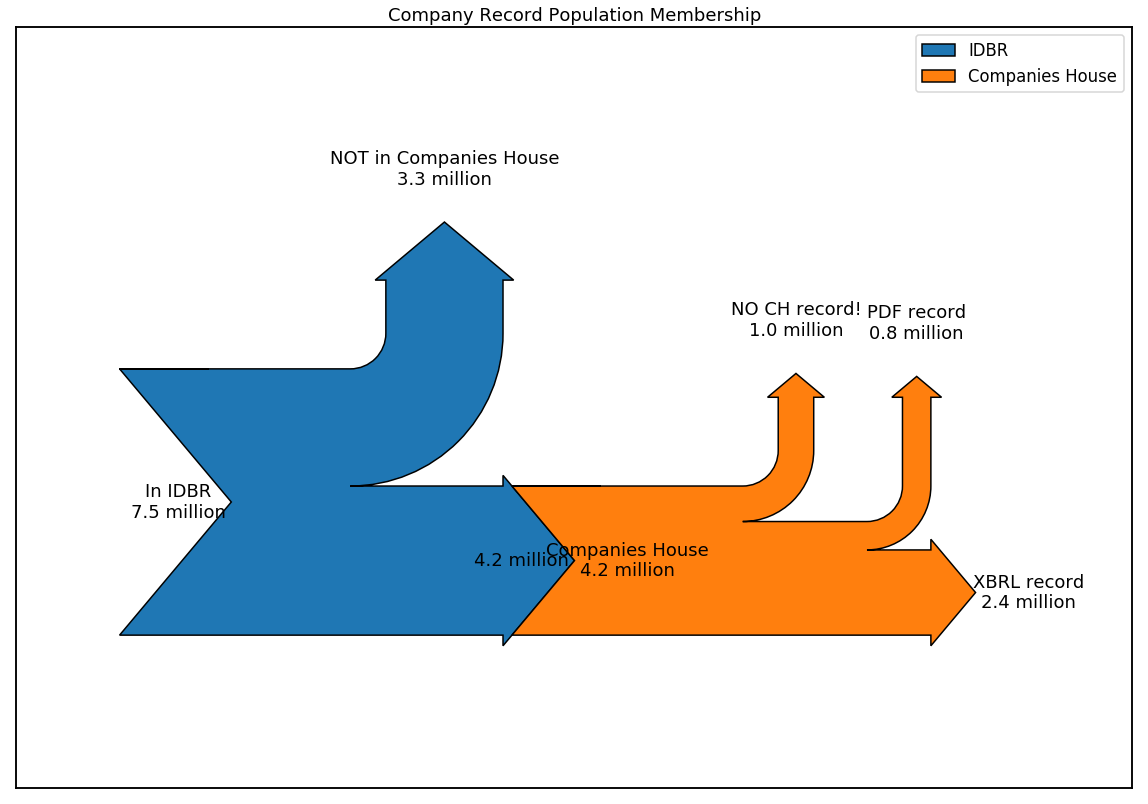

In [18]:
sns.set_context("talk")

labelset = ["IDBR",
            "Not in Companies House",
            "Doesn't have CH record!",
            "Has a PDF record",
            "Has an electronic record"]

flowset = [7.5, -3.3, -1.0, -0.8, -2.4]

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[],
                     title="Company Record Population Membership")

sankey = Sankey(ax=ax, scale=0.1, format='%.1f', unit=' million')

sankey.add(flows = [7.5, -3.3, -4.2],
           label = "IDBR",
           labels = ["In IDBR", "NOT in Companies House", "Companies House"],
           orientations=[0, 1, 0])

sankey.add(flows = [4.2, -1.0, -0.8, -2.4],
           label = "Companies House",
           labels = ["", "NO CH record!", "PDF record", "XBRL record"],
           orientations = [0, 1, 1, 0],
           prior = 0,
           connect = (2, 0))

sankey.finish()
plt.legend()

fig.savefig("sankey_losses.png")